# 🍔👁 Food Vision Big™


We're going to be building Food Vision Big™, using all of the data from the Food101 dataset.

Yep. All 75,750 training images and 25,250 testing images.

And guess what...

This time **we've got the goal of beating [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)**, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.


|  | 🍔👁 Food Vision Big™ |
|-----|-----|
| Dataset source | TensorFlow Datasets |
| Train data | 75,750 images |
| Test data | 25,250 images |  
| Mixed precision | Yes |
| Data loading | Performanant tf.data API |
| Target results | 77.4% top-1 accuracy (beat [DeepFood paper](https://arxiv.org/abs/1606.05675)) | 50.76% top-1 accuracy (beat [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)) |





In [1]:
import tensorflow as tf

In [2]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

--2023-08-13 08:24:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-13 08:24:22 (74.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f1312548-f272-a1a3-17d1-0433a7bee8c9)


In [4]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

# Getting the data ready

Using tensorflow datasets

In [5]:
# Tensorflow datasets
import tensorflow_datasets as tfds

In [6]:
# Get all available datasets in tds
dataset_list = tfds.list_builders()
print('food101' in dataset_list)

True


In [7]:
(train_data, test_data), ds_info = tfds.load('food101',
                                             split=['train', 'validation'],
                                             as_supervised=True,
                                             with_info=True,
                                             shuffle_files=True
                                             )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteB0J9TZ/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteB0J9TZ/food101-validation.tfrecord*...:   0%|     …

In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
class_names = ds_info.features['label'].names

In [10]:
train_one_sample = train_data.take(1)

In [11]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class: {class_names[label]}
  """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class: chocolate_cake
  


In [13]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

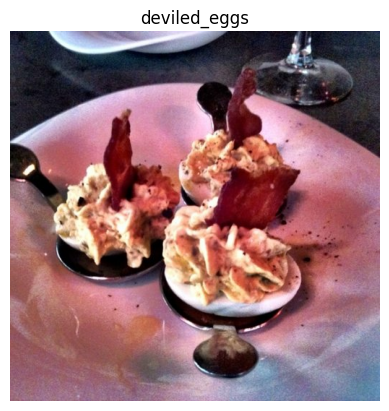

Shape: (512, 512, 3)


In [14]:
import matplotlib.pyplot as plt
(take_sample,) = train_data.take(1)
image, label = take_sample
plt.title(class_names[label])
plt.imshow(image)
plt.axis('off')
plt.show();
print(f"Shape: {image.shape}")

## Preprocessing the image

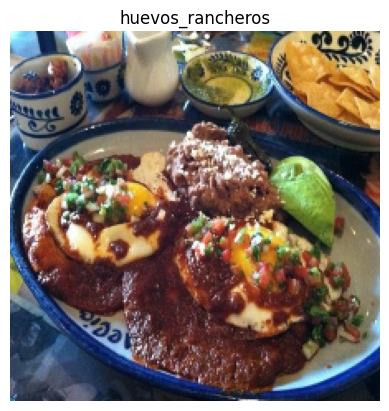

Shape: (224, 224, 3)


In [15]:
import matplotlib.pyplot as plt
(take_sample,) = train_data.take(1)
image, label = take_sample
plt.title(class_names[label])
preprocessed_image = tf.cast(image, tf.float32)* (1. / 255) # Normalize
preprocessed_image = tf.image.resize(preprocessed_image, (224,224)) # Resizing
plt.imshow(preprocessed_image)
plt.axis('off')
plt.show();
print(f"Shape: {preprocessed_image.shape}")

In [16]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, size=(img_shape, img_shape))
    return image, label

In [17]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_image.dtype}")

Image before preprocessing:
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[230.65816  253.64285  251.      ]
  [222.99998  254.97449  252.19388 ]
  [207.06633  255.       250.36734 ]
  ...
  [140.66287  129.52519  121.22428 ]
  [121.14268  115.265144 116.95397 ]
  [ 83.95363   83.08119   89.63737 ]]

 [[221.47449  254.37755  253.33163 ]
  [214.5102   255.       253.92348 ]
  [198.41327  254.58673  251.96939 ]
  ...
  [208.66318  195.82143  173.40823 ]
  [197.03056  190.1071   174.83162 ]
  [175.54036  171.6169   161.21384 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


In [18]:
def create_dataset(dataset):
  dataset = dataset.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE) # Utilize all CPU
  dataset = dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
  return dataset

In [19]:
train_data = create_dataset(train_data)
test_data = create_dataset(test_data)

In [20]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# Callbacks

In [21]:
# Tensorboard callbacks
from helper_functions import create_tensorboard_callback

# Model Checkpoint
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_accuracy',
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

# Modelling and Setting up mixed precision

In [22]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy(policy='mixed_float16')

In [74]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(224, 224, 3), name='input_layer')

base_model = tf.keras.applications.efficientnet.EfficientNetB2(include_top=False)
base_model.trainable = False

x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)

outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)

model = tf.keras.Model(inputs, outputs, name='efficientb2')
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "efficientb2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb2 (Functional)  (None, None, None, 1408)  7768569  
                                                                 
 global_average_pooling2d_1   (None, 1408)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 101)               142309    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 7,910,878
Trainable params: 142,309
Non-t

In [29]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb2 False float32 <Policy "mixed_float16">
global_average_pooling2d_1 True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [30]:
for layer in model.layers[1].layers[:5]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

for _ in range(3):
  print('.')

for layer in model.layers[1].layers[-5:]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
rescaling_3 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
.
.
.
block7b_drop False float32 <Policy "mixed_float16">
block7b_add False float32 <Policy "mixed_float16">
top_conv False float32 <Policy "mixed_float16">
top_bn False float32 <Policy "mixed_float16">
top_activation False float32 <Policy "mixed_float16">


In [31]:
initial_epochs = 5

In [32]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=initial_epochs,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb2_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb2_101_classes_all_data_feature_extract/20230813-084240
Epoch 1/5
2368/2368 [==============================] - 260s 101ms/step - loss: 1.7916 - accuracy: 0.5614 - val_loss: 1.1544 - val_accuracy: 0.6891
Epoch 2/5
2368/2368 [==============================] - 244s 102ms/step - loss: 1.2996 - accuracy: 0.6625 - val_loss: 1.0507 - val_accuracy: 0.7180
Epoch 3/5
2368/2368 [==============================] - 236s 98ms/step - loss: 1.1648 - accuracy: 0.6929 - val_loss: 1.0190 - val_accuracy: 0.7256
Epoch 4/5
2368/2368 [==============================] - 243s 101ms/step - loss: 1.0812 - accuracy: 0.7126 - val_loss: 0.9950 - val_accuracy: 0.7280
Epoch 5/5
2368/2368 [==============================] - 248s 104ms/step - loss: 1.0181 - accuracy: 0.7288 - val_loss: 0.9936 - val_accuracy: 0.7262


In [33]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 76s 93ms/step - loss: 1.0071 - accuracy: 0.7223


[1.0071440935134888, 0.7222970128059387]

# Fine-Tuning EfficientNet

In [75]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-300]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [56]:
for layer in model.layers[1].layers[:5]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

for _ in range(3):
  print('.')

for layer in model.layers[1].layers[-5:]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
rescaling_3 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
.
.
.
block7b_drop True float32 <Policy "mixed_float16">
block7b_add True float32 <Policy "mixed_float16">
top_conv True float32 <Policy "mixed_float16">
top_bn True float32 <Policy "mixed_float16">
top_activation True float32 <Policy "mixed_float16">


In [77]:
model.summary()

Model: "efficientb2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb2 (Functional)  (None, None, None, 1408)  7768569  
                                                                 
 global_average_pooling2d_4   (None, 1408)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 101)               142309    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 7,910,878
Trainable params: 7,837,143
Non

In [78]:
# Refit the model (same as model except with more trainable layers)
fine_tuned_efficientb2 = model.fit(train_data,
                                  epochs=3,
                                  validation_data=test_data,
                                  validation_steps=int(0.15 * len(test_data)))

Epoch 1/3
2368/2368 [==============================] - 492s 207ms/step - loss: 1.7163 - accuracy: 0.5909 - val_loss: 0.7716 - val_accuracy: 0.7918
Epoch 2/3
2368/2368 [==============================] - 498s 209ms/step - loss: 0.8769 - accuracy: 0.7667 - val_loss: 0.6145 - val_accuracy: 0.8252
Epoch 3/3
2368/2368 [==============================] - 488s 204ms/step - loss: 0.5991 - accuracy: 0.8361 - val_loss: 0.6129 - val_accuracy: 0.8321


In [79]:
fine_tuned_efficientb2_result = model.evaluate(test_data)
fine_tuned_efficientb2_result

790/790 [==============================] - 75s 92ms/step - loss: 0.6103 - accuracy: 0.8286


[0.6102990508079529, 0.8286336660385132]